## Code Sandbox

In [81]:
import torch
import torch.nn as nn
import numpy as np
import time
import math
import pandas as pd
from matplotlib import pyplot, pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt

In [82]:
torch.manual_seed(0)
np.random.seed(0)

# S is the source sequence length
# T is the target sequence length
# N is the batch size
# E is the feature number

# src = torch.rand((10, 32, 512)) # (S,N,E)
# tgt = torch.rand((20, 32, 512)) # (T,N,E)
# out = transformer_model(src, tgt)

input_window = 100  # number of input steps
output_window = 1  # number of prediction steps, in this model its fixed to one
batch_size = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# looks like normalizing input values curtial for the model
scaler = MinMaxScaler(feature_range=(-1, 1))

In [83]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        # pe.requires_grad = False
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

In [84]:
class TransAm(nn.Module):
    def __init__(self, feature_size=250, num_layers=1, dropout=0.1):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'

        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=10, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(feature_size, 1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)  # , self.src_mask)
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

In [85]:
# if window is 100 and prediction step is 1
# in -> [0..99]
# target -> [1..100]
def create_inout_sequences(input_data, tw):
    '''
    Creates input sequence
    :param input_data: train or validation data
    :param tw: input window
    :return:
    '''
    inout_seq = []
    L = len(input_data)
    for i in range(L - tw):
        # input data is packed in input window sized "packages"
        train_seq = input_data[i:i + tw]
        # input data with time shift depending on output window
        train_label = input_data[i + output_window:i + tw + output_window]
        # train data and labels are packed together into tuples
        inout_seq.append((train_seq, train_label))
    return torch.FloatTensor(inout_seq)

In [86]:
def split_data(x, y):
    percentage = int(0.85 * len(y))
    train_data_x = x[0:percentage]
    test_data_x = x[percentage:]
    train_data_y = y[0:percentage]
    test_data_y = y[percentage:]
    return train_data_x, train_data_y, test_data_x, test_data_y

In [87]:
def get_data_old():
    # construct a little toy dataset
    time = np.arange(0, 400, 0.1)
    amplitude = np.sin(time) + np.sin(time * 0.05) + np.sin(time * 0.12) * np.random.normal(-0.2, 0.2, len(time))

    # loading weather data from a file
    # from pandas import read_csv
    # series = read_csv('daily-min-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)

    # looks like normalizing input values curtial for the model
    scaler = MinMaxScaler(feature_range=(-1, 1))
    # amplitude = scaler.fit_transform(series.to_numpy().reshape(-1, 1)).reshape(-1)
    amplitude = scaler.fit_transform(amplitude.reshape(-1, 1)).reshape(-1)

    sampels = 2600
    train_data = amplitude[:sampels]
    test_data = amplitude[sampels:]

    # convert our train data into a pytorch train tensor
    # train_tensor = torch.FloatTensor(train_data).view(-1)
    # todo: add comment..
    train_sequence = create_inout_sequences(train_data, input_window)
    train_sequence = train_sequence[
                     :-output_window]  # todo: fix hack? -> din't think this through, looks like the last n sequences are to short, so I just remove them. Hackety Hack..

    # test_data = torch.FloatTensor(test_data).view(-1)
    test_data = create_inout_sequences(test_data, input_window)
    test_data = test_data[:-output_window]  # todo: fix hack?

    return train_sequence.to(device), test_data.to(device)

In [88]:
def get_data():

    # My Code
    df = pd.read_csv('data/GlobalTemperatures.csv', parse_dates=[0])
    df = df.dropna(subset=['dt', 'LandAverageTemperature'])
    df = df.iloc[1789:len(df)-23, 0:2]  # start 1900-01-01 end 2014-01-01, reserving one year for test
    train_data_x, train_data_y, test_data_x, test_data_y = split_data(df['dt'], df['LandAverageTemperature'])

    plt.figure(facecolor='white', figsize=(17, 8))
    plt.plot(train_data_x, train_data_y)
    plt.plot(test_data_x, test_data_y)
    plt.savefig('./graph/train_test_data')
    plt.close()

    print("NaN values in train_data: " + str(train_data_y.isna().sum()))
    print("NaN values in test_data: " + str(test_data_y.isna().sum()))

    # todo: WARNING! x and y don't match after removing NaN this way - fix in line 148
    # train_data_y = train_data_y.dropna()
    # test_data_y = test_data_y.dropna()

    train_data = train_data_y.to_numpy()
    test_data = test_data_y.to_numpy()

    train_data = scaler.fit_transform(train_data.reshape(-1, 1)).reshape(-1)
    test_data = scaler.fit_transform(test_data.reshape(-1, 1)).reshape(-1)

    # convert our train data into a pytorch train tensor
    # train_tensor = torch.FloatTensor(train_data).view(-1)
    # todo: add comment.. 
    train_sequence = create_inout_sequences(train_data, input_window)
    train_sequence = train_sequence[
                     :-output_window]  # todo: fix hack? -> din't think this through, looks like the last n sequences are to short, so I just remove them. Hackety Hack..

    # test_data = torch.FloatTensor(test_data).view(-1)
    test_data = create_inout_sequences(test_data, input_window)
    test_data = test_data[:-output_window]  # todo: fix hack?

    return train_sequence.to(device), test_data.to(device)

In [89]:
def get_batch(source, i, batch_size):
    '''

    :param source:
    :param i:
    :param batch_size:
    :return:
    '''
    seq_len = min(batch_size, len(source) - 1 - i)
    data = source[i:i + seq_len]
    input = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window, 1))  # 1 is feature size
    target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window, 1))
    return input, target

In [90]:
def train(train_data):
    model.train()  # Turn on the train mode \o/
    total_loss = 0.
    start_time = time.time()

    for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):
        data, targets = get_batch(train_data, i, batch_size)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, targets)
        # explanation https://stackoverflow.com/questions/53975717/pytorch-connection-between-loss-backward-and-optimizer-step
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.7)
        optimizer.step()

        total_loss += loss.item()
        log_interval = int(len(train_data) / batch_size / 5)
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.6f} | {:5.2f} ms | '
                  'loss {:5.5f} | ppl {:8.2f}'.format(
                epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
                              elapsed * 1000 / log_interval,
                cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

In [91]:
def plot_and_loss(eval_model, data_source, epoch):
    eval_model.eval()
    total_loss = 0.
    test_result = torch.Tensor(0)
    truth = torch.Tensor(0)
    with torch.no_grad():
        for i in range(0, len(data_source) - 1):
            data, target = get_batch(data_source, i, 1)
            output = eval_model(data)
            total_loss += criterion(output, target).item()
            test_result = torch.cat((test_result, output[-1].view(-1).cpu()), 0)
            truth = torch.cat((truth, target[-1].view(-1).cpu()), 0)

In [92]:
def plot_and_loss(eval_model, data_source, epoch):
    eval_model.eval()
    total_loss = 0.
    test_result = torch.Tensor(0)
    truth = torch.Tensor(0)
    with torch.no_grad():
        for i in range(0, len(data_source) - 1):
            data, target = get_batch(data_source, i, 1)
            output = eval_model(data)
            total_loss += criterion(output, target).item()
            test_result = torch.cat((test_result, output[-1].view(-1).cpu()), 0)
            truth = torch.cat((truth, target[-1].view(-1).cpu()), 0)

    # test_result = test_result.cpu().numpy() -> no need to detach stuff..
    len(test_result)

    pyplot.figure(facecolor='white', figsize=(17, 8))
    pyplot.plot(test_result, color="red", label="test_result")
    pyplot.plot(truth[:500], color="blue", label="truth")
    pyplot.plot(test_result - truth, color="green", label="test_result - truth")
    pyplot.grid(True, which='both')
    pyplot.legend()
    pyplot.axhline(y=0, color='k')
    pyplot.savefig('graph/transformer-epoch%d.png' % epoch)
    pyplot.close()

    return total_loss / i

In [93]:
# predict the next n steps based on the input data 
def predict_future(eval_model, data_source, steps):
    eval_model.eval()
    total_loss = 0.
    test_result = torch.Tensor(0)
    truth = torch.Tensor(0)
    data, _ = get_batch(data_source, 0, 1)
    with torch.no_grad():
        for i in range(0, steps):
            output = eval_model(data[-input_window:])
            data = torch.cat((data, output[-1:]))

    data = data.cpu().view(-1)

    # I used this plot to visualize if the model pics up any long therm struccture within the data.
    pyplot.figure(facecolor='white', figsize=(17, 8))
    pyplot.plot(data, color="red")
    pyplot.plot(data[:input_window], color="blue")
    pyplot.grid(True, which='both')
    pyplot.axhline(y=0, color='k')
    pyplot.savefig('graph/transformer-future%d.png' % steps)
    pyplot.close()
    return data

In [94]:
def evaluate(eval_model, data_source):
    '''

    :param eval_model:
    :param data_source: validation data
    :return:
    '''
    eval_model.eval()  # Turn on the evaluation mode
    total_loss = 0.
    eval_batch_size = 300
    with torch.no_grad():
        for i in range(0, len(data_source) - 1, eval_batch_size):
            data, targets = get_batch(data_source, i, eval_batch_size)
            output = eval_model(data)
            total_loss += len(data[0]) * criterion(output, targets).cpu().item()
    return total_loss / len(data_source)

In [95]:
pd.date_range(start="2014-01-01", end="2015-01-01", freq='M')

DatetimeIndex(['2014-01-31', '2014-02-28', '2014-03-31', '2014-04-30',
               '2014-05-31', '2014-06-30', '2014-07-31', '2014-08-31',
               '2014-09-30', '2014-10-31', '2014-11-30', '2014-12-31'],
              dtype='datetime64[ns]', freq='M')

In [96]:
def one_year_prediction(model, val_data, epochs):
    '''
    generate prediction for one year and safe plot
    :param model:
    :param val_data:
    :return:
    '''
    df = pd.read_csv("./data/GlobalTemperatures.csv")
    df = df.iloc[len(df) - 23:len(df) - 11, 0:2]
    data = predict_future(model, val_data, 12)
    data = scaler.inverse_transform(data.reshape(-1, 1))
    
    # range of timestamps
    timestamp_range = pd.date_range(start="2014-01-01", end="2015-01-01", freq='M')
    
    plt.figure(facecolor='white', figsize = (17, 8))
    plt.rc('axes', titlesize=20)
    plt.rc('axes', labelsize=16)
    plt.rc('xtick', labelsize=12)
    plt.rc('ytick', labelsize=12) 
    #test[['Temp', 'Pred']].plot(figsize=(22,6))
    plt.plot(timestamp_range, df['LandAverageTemperature'].to_numpy(), label='Real Temp.')
    plt.plot(timestamp_range, data[len(data)-14:len(data)-2], label='Predicted Temp.')
    plt.title('Transformer Forecast')
    plt.xlabel('Date')
    plt.ylabel('Avg. C°')
    plt.legend(prop={'size': 16})
    plt.savefig('./graph/Transformer-Forecast-'+str(epochs))
    plt.show()
    
    bias = data[len(data)-14:len(data)-2].mean()-df['LandAverageTemperature'].to_numpy().mean()
    rmse = measure_rmse(df['LandAverageTemperature'].to_numpy(), data[len(data)-14:len(data)-2])
    return bias, rmse

In [97]:
def measure_rmse(y_true, y_pred):
    # mit der Wurzel (sqrt) wird aus dem MSE der RMSE https://www.statology.org/mse-vs-rmse/
    return sqrt(mean_squared_error(y_true,y_pred))

In [98]:
train_data, val_data = get_data()
# train_data, val_data = get_data_old()
model = TransAm().to(device)

criterion = nn.MSELoss()
lr = 0.005
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

best_val_loss = float("inf")
epochs = 50  # The number of epochs
best_model = None

NaN values in train_data: 0
NaN values in test_data: 0


In [99]:
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(train_data)

    if epoch % 10 == 0:
        val_loss = plot_and_loss(model, val_data, epoch)
        predict_future(model, val_data, 200)
    else:
        val_loss = evaluate(model, val_data)

    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.5f} | valid ppl {:8.2f}'.format(epoch, (
            time.time() - epoch_start_time),
                                                                                                  val_loss,
                                                                                                  math.exp(val_loss)))
    print('-' * 89)

    # if val_loss < best_val_loss:
    #    best_val_loss = val_loss
    #    best_model = model

    scheduler.step()

C:\Users\Lukas\Documents\Projects\transformer-time-series-prediction\venv\lib\site-packages\torch\optim\lr_scheduler.py:371: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch   1 |    21/  106 batches | lr 0.005000 | 23.24 ms | loss 9.14544 | ppl  9371.65
| epoch   1 |    42/  106 batches | lr 0.005000 | 13.95 ms | loss 0.16762 | ppl     1.18
| epoch   1 |    63/  106 batches | lr 0.005000 | 13.31 ms | loss 0.11528 | ppl     1.12
| epoch   1 |    84/  106 batches | lr 0.005000 | 13.51 ms | loss 0.10510 | ppl     1.11
| epoch   1 |   105/  106 batches | lr 0.005000 | 13.24 ms | loss 0.10137 | ppl     1.11
-----------------------------------------------------------------------------------------
| end of epoch   1 | time:  1.66s | valid loss 0.11104 | valid ppl     1.12
-----------------------------------------------------------------------------------------
| epoch   2 |    21/  106 batches | lr 0.004513 | 13.93 ms | loss 0.10668 | ppl     1.11
| epoch   2 |    42/  106 batches | lr 0.004513 | 13.19 ms | loss 0.08525 | ppl     1.09
| epoch   2 |    63/  106 batches | lr 0.004513 | 13.37 ms | loss 0.08408 | ppl     1.09
| epoch   2 |    84/  106 batche

| epoch  13 |    21/  106 batches | lr 0.002567 | 14.14 ms | loss 0.01182 | ppl     1.01
| epoch  13 |    42/  106 batches | lr 0.002567 | 13.62 ms | loss 0.00755 | ppl     1.01
| epoch  13 |    63/  106 batches | lr 0.002567 | 13.34 ms | loss 0.00611 | ppl     1.01
| epoch  13 |    84/  106 batches | lr 0.002567 | 13.33 ms | loss 0.00620 | ppl     1.01
| epoch  13 |   105/  106 batches | lr 0.002567 | 13.58 ms | loss 0.00711 | ppl     1.01
-----------------------------------------------------------------------------------------
| end of epoch  13 | time:  1.46s | valid loss 0.00868 | valid ppl     1.01
-----------------------------------------------------------------------------------------
| epoch  14 |    21/  106 batches | lr 0.002438 | 14.14 ms | loss 0.01157 | ppl     1.01
| epoch  14 |    42/  106 batches | lr 0.002438 | 13.33 ms | loss 0.00721 | ppl     1.01
| epoch  14 |    63/  106 batches | lr 0.002438 | 13.32 ms | loss 0.00584 | ppl     1.01
| epoch  14 |    84/  106 batche

| epoch  25 |    21/  106 batches | lr 0.001387 | 17.81 ms | loss 0.00885 | ppl     1.01
| epoch  25 |    42/  106 batches | lr 0.001387 | 16.62 ms | loss 0.00534 | ppl     1.01
| epoch  25 |    63/  106 batches | lr 0.001387 | 16.71 ms | loss 0.00450 | ppl     1.00
| epoch  25 |    84/  106 batches | lr 0.001387 | 16.64 ms | loss 0.00447 | ppl     1.00
| epoch  25 |   105/  106 batches | lr 0.001387 | 16.62 ms | loss 0.00522 | ppl     1.01
-----------------------------------------------------------------------------------------
| end of epoch  25 | time:  1.82s | valid loss 0.00841 | valid ppl     1.01
-----------------------------------------------------------------------------------------
| epoch  26 |    21/  106 batches | lr 0.001318 | 18.14 ms | loss 0.00882 | ppl     1.01
| epoch  26 |    42/  106 batches | lr 0.001318 | 16.29 ms | loss 0.00484 | ppl     1.00
| epoch  26 |    63/  106 batches | lr 0.001318 | 16.57 ms | loss 0.00401 | ppl     1.00
| epoch  26 |    84/  106 batche

| epoch  37 |    21/  106 batches | lr 0.000749 | 17.88 ms | loss 0.00751 | ppl     1.01
| epoch  37 |    42/  106 batches | lr 0.000749 | 16.48 ms | loss 0.00439 | ppl     1.00
| epoch  37 |    63/  106 batches | lr 0.000749 | 16.57 ms | loss 0.00378 | ppl     1.00
| epoch  37 |    84/  106 batches | lr 0.000749 | 16.62 ms | loss 0.00361 | ppl     1.00
| epoch  37 |   105/  106 batches | lr 0.000749 | 16.76 ms | loss 0.00436 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch  37 | time:  1.82s | valid loss 0.00620 | valid ppl     1.01
-----------------------------------------------------------------------------------------
| epoch  38 |    21/  106 batches | lr 0.000712 | 18.05 ms | loss 0.00714 | ppl     1.01
| epoch  38 |    42/  106 batches | lr 0.000712 | 16.43 ms | loss 0.00413 | ppl     1.00
| epoch  38 |    63/  106 batches | lr 0.000712 | 16.57 ms | loss 0.00370 | ppl     1.00
| epoch  38 |    84/  106 batche

| epoch  49 |    21/  106 batches | lr 0.000405 | 17.71 ms | loss 0.00696 | ppl     1.01
| epoch  49 |    42/  106 batches | lr 0.000405 | 16.33 ms | loss 0.00394 | ppl     1.00
| epoch  49 |    63/  106 batches | lr 0.000405 | 16.52 ms | loss 0.00340 | ppl     1.00
| epoch  49 |    84/  106 batches | lr 0.000405 | 16.39 ms | loss 0.00329 | ppl     1.00
| epoch  49 |   105/  106 batches | lr 0.000405 | 16.48 ms | loss 0.00404 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch  49 | time:  1.80s | valid loss 0.00531 | valid ppl     1.01
-----------------------------------------------------------------------------------------
| epoch  50 |    21/  106 batches | lr 0.000385 | 17.99 ms | loss 0.00700 | ppl     1.01
| epoch  50 |    42/  106 batches | lr 0.000385 | 16.43 ms | loss 0.00406 | ppl     1.00
| epoch  50 |    63/  106 batches | lr 0.000385 | 16.55 ms | loss 0.00343 | ppl     1.00
| epoch  50 |    84/  106 batche

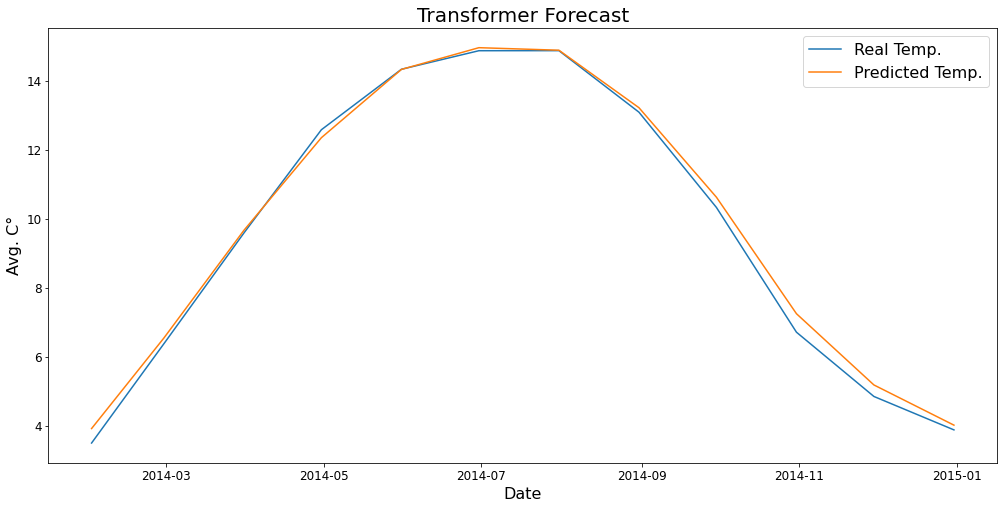

Bias: 0.16361948302326113 RMSE: 0.2572164704756892


In [100]:
bias, rmse = one_year_prediction(model, val_data, epochs)
print('Bias: ' + str(bias) + ' RMSE: ' + str(rmse))

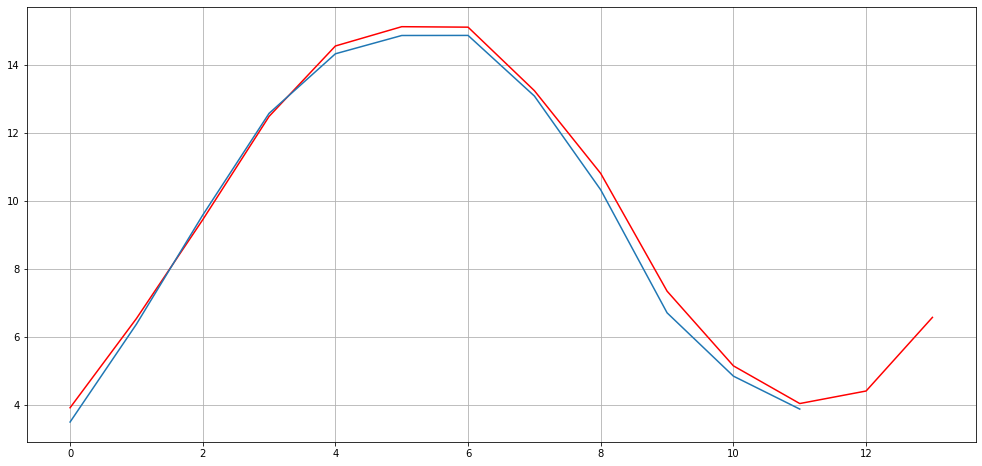

In [75]:
df = pd.read_csv("./data/GlobalTemperatures.csv")
df = df.iloc[len(df) - 23:len(df) - 11, 0:2]
data = predict_future(model, val_data, 12)
data = scaler.inverse_transform(data.reshape(-1, 1))#print(data)
pyplot.figure(facecolor='white', figsize=(17, 8))
pyplot.plot(data[len(data)-14:], color="red")
# das wird dem Model gegeben, es braucht 100 inputs um einen output zu generieren, weil so eingestellt
#pyplot.plot(data[:input_window], color="blue") 
pyplot.plot(df['LandAverageTemperature'].to_numpy())
pyplot.grid(True, which='both')
#pyplot.axhline(y=0, color='k')
#pyplot.savefig('graph/one_year_prediction.png')
#pyplot.close()

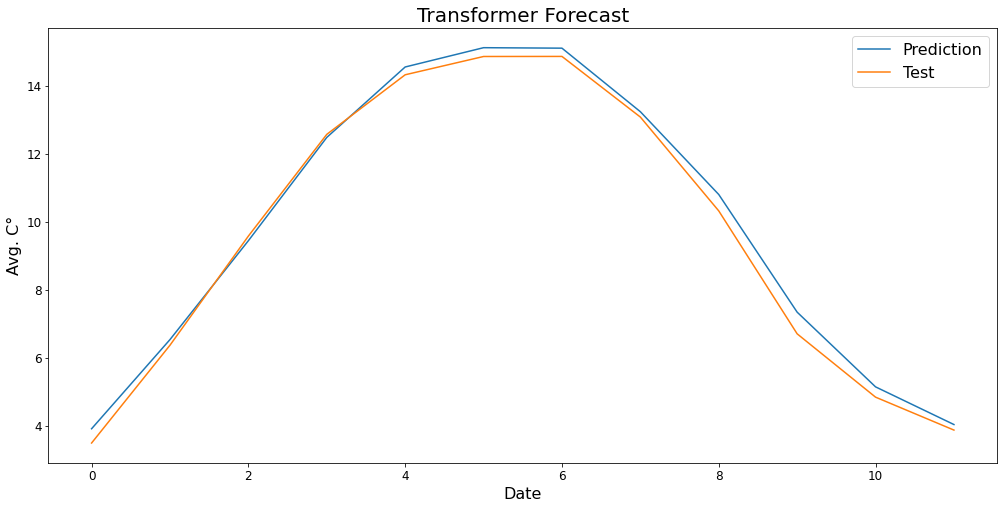

In [82]:
plt.figure(facecolor='white', figsize = (17, 8))
plt.rc('axes', titlesize=20) 
plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
#test[['Temp', 'Pred']].plot(figsize=(22,6))
plt.plot(data[len(data)-14:len(data)-2], label='Prediction')
pyplot.plot(df['LandAverageTemperature'].to_numpy(), label='Test')
plt.title('Transformer Forecast')
plt.xlabel('Date')
plt.ylabel('Avg. C°')
plt.legend(prop={'size': 16})
plt.savefig('./graph/Transformer-Forecast')
plt.show()